## DDA3020 Autumn 2023 Homework 4

### Programming Task 2.2

#### student ID: 121090429
#### Name: Ou Ziyi

--------------------------------------------------------------------------------------------------------------------------


In [102]:
import numpy as np

np.random.seed(55)  # set seed for reproducibility

## 1. Two clustering algorithms

### (1) K-means

In [103]:
class KMeans:
    def __init__(self, n_clusters, max_iters=100):
        self.n_clusters = n_clusters
        self.max_iters = max_iters

    def fit(self, X):
        n_samples, n_features = X.shape

        # Initialize centroids randomly
        centroids = X[np.random.choice(n_samples, self.n_clusters, replace=False)]
        
        for _ in range(self.max_iters):
            # Assign each point to the nearest centroid
            labels = np.argmin(np.linalg.norm(X[:, np.newaxis] - centroids, axis=2), axis=1)
            
            # Update centroids
            new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(self.n_clusters)])
            
            # Check for convergence
            if np.all(centroids == new_centroids):
                break
            
            centroids = new_centroids

        self.centroids = centroids
        self.labels = labels


### (2) GMM

In [104]:
from scipy.stats import multivariate_normal

class GMM:
    def __init__(self, n_components, max_iters=100,allow_singular=True):
        self.n_components = n_components
        self.max_iters = max_iters
        self.weights = None
        self.means = None
        self.covariances = None
        self.labels = None  # Add labels attribute

    def fit(self, X):
        n_samples, n_features = X.shape

        # Initialize parameters
        self.weights = np.ones(self.n_components) / self.n_components
        self.means = X[np.random.choice(n_samples, self.n_components, replace=False)]
        self.covariances = [np.cov(X.T) for _ in range(self.n_components)]

        for _ in range(self.max_iters):
            # Expectation step
            responsibilities = np.array([self.weights[i] * multivariate_normal.pdf(X, self.means[i], self.covariances[i]) for i in range(self.n_components)]).T
            responsibilities /= responsibilities.sum(axis=1, keepdims=True)

            # Maximization step
            Nk = responsibilities.sum(axis=0)
            self.weights = Nk / n_samples
            self.means = np.dot(responsibilities.T, X) / Nk[:, np.newaxis]
            self.covariances = [np.dot((X - self.means[i]).T, responsibilities[:, i][:, np.newaxis] * (X - self.means[i])) / Nk[i] for i in range(self.n_components)]

        # Assign labels based on the probability distribution
        self.labels = np.argmax(responsibilities, axis=1)
        return self

    def predict_proba(self, X):
        responsibilities = np.array([self.weights[i] * multivariate_normal.pdf(X, self.means[i], self.covariances[i]) for i in range(self.n_components)]).T
        responsibilities /= responsibilities.sum(axis=1, keepdims=True)
        return responsibilities

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

## 2. Three evaluation metrics

### (1) Silhouette Coefficient

In [105]:
import numpy as np

def silhouette_coefficient(X, labels):
    n_samples = len(X)
    a = np.zeros(n_samples)
    b = np.zeros(n_samples)

    for i in range(n_samples):
        cluster_i = labels[i]
        cluster_i_points = X[labels == cluster_i]
        a[i] = np.mean(np.linalg.norm(X[i] - cluster_i_points, axis=1))

        other_clusters = [j for j in range(len(np.unique(labels))) if j != cluster_i]
        min_distances = np.zeros(len(other_clusters))

        for idx, cluster_j in enumerate(other_clusters):
            cluster_j_points = X[labels == cluster_j]
            min_distances[idx] = np.mean(np.linalg.norm(X[i] - cluster_j_points, axis=1))

        b[i] = np.min(min_distances)

    s = (b - a) / np.maximum(a, b)
    return np.mean(s)

### (2) Rand Index

In [106]:
def rand_index(true_labels, pred_labels):
    n = len(true_labels)
    a, b = 0, 0

    for i in range(n):
        for j in range(i + 1, n):
            same_true = true_labels[i] == true_labels[j]
            same_pred = pred_labels[i] == pred_labels[j]

            if same_true and same_pred:
                a += 1
            elif not same_true and not same_pred:
                b += 1

    # Rand Index = (a + b) / C(n, 2)
    return (a + b) / (n * (n - 1) / 2)

### (3) Normalized Mutual Information (NMI)

In [107]:
def NMI(true_labels, pred_labels):
    def entropy(labels):
        unique_labels, counts = np.unique(labels, return_counts=True)
        probabilities = counts / len(labels)
        return -np.sum(probabilities * np.log2(probabilities))

    # Mutual Information
    h_true = entropy(true_labels)
    h_pred = entropy(pred_labels)
    h_joint = entropy(np.vstack((true_labels, pred_labels)).T)

    mi = h_true + h_pred - h_joint

    # Normalized Mutual Information
    nmi = mi / np.sqrt(h_true * h_pred)
    return nmi

## 3. Data preparation

In [108]:
# import data
import pandas as pd
import os
current_directory = os.getcwd()
vowel = pd.read_csv(os.path.join(current_directory,'Vowel.csv'), header=0)
vowel_features = vowel.iloc[:, :-1]
vowel_true_label = vowel.iloc[:, -1]

In [109]:
'''The class in the dataset Vowel is written in string, so we need to convert it into integer.'''
def label_encoder(labels):   
    unique_labels = np.unique(labels)
    label_dict = {label: idx for idx, label in enumerate(unique_labels)}
    return np.array([label_dict[label] for label in labels])

## 4. Plot s and RI for different k & Get optimal k & Get NMI for s and RI with optimal k

In [110]:
import matplotlib.pyplot as plt

# Define a range of k values
k_values = range(2, 12)

### 4.1 K-means

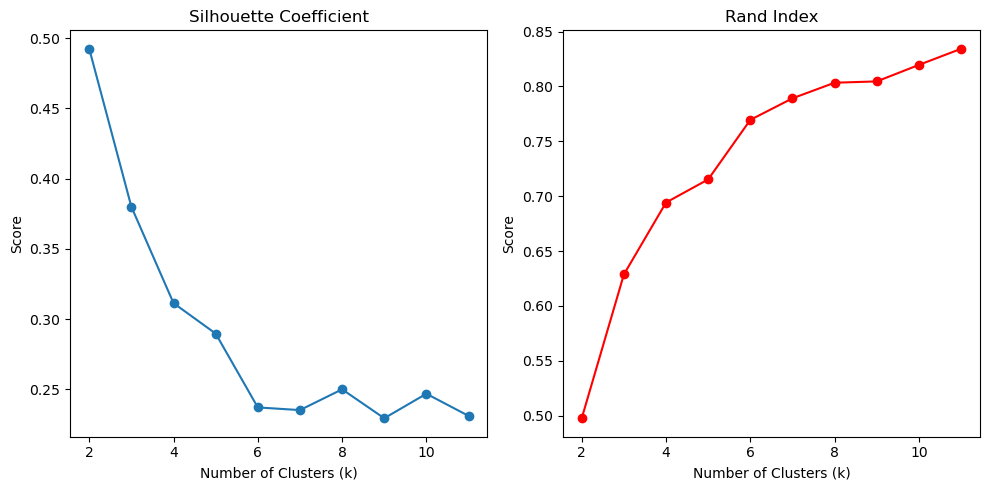

K-means algorithm:
Optimal k for Silhouette Coefficient: 2
Optimal k for Rand Index: 11
NMI for Silhouette Coefficient (k = 2 ): 0.39392317145655925
NMI for Rand Index (k = 11 ): 0.5732928049507543


In [111]:
# Initialize lists to store metric values
silhouette_scores = []
rand_index_scores = []

# Iterate over different values of k
for k in k_values:
    # Apply K-means on vowel dataset
    kmeans_vowel = KMeans(n_clusters=k)
    kmeans_vowel.fit(vowel_features.values)
    kmeans_labels_vowel = kmeans_vowel.labels

    # Calculate Silhouette Coefficient
    silhouette_score = silhouette_coefficient(vowel_features.values, kmeans_labels_vowel)
    silhouette_scores.append(silhouette_score)

    # Calculate Rand Index
    rand_index_score = rand_index(vowel_true_label.values, kmeans_labels_vowel)
    rand_index_scores.append(rand_index_score)

# Plot Silhouette Coefficient
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(k_values, silhouette_scores, marker='o')
plt.title('Silhouette Coefficient')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Score')

# Plot Rand Index
plt.subplot(1, 2, 2)
plt.plot(k_values, rand_index_scores, marker='o', color='r')
plt.title('Rand Index')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Score')

plt.tight_layout()
plt.show()

# Find the optimal k for Silhouette Coefficient and Rand Index
optimal_k_silhouette = k_values[np.argmax(silhouette_scores)]
optimal_k_rand_index = k_values[np.argmax(rand_index_scores)]

# Output the selected k values
print("K-means algorithm:")
print("Optimal k for Silhouette Coefficient:", optimal_k_silhouette)
print("Optimal k for Rand Index:", optimal_k_rand_index)

# Calculate and output NMI for the selected k values
# Convert string labels to integers for NMI calculation
vowel_true_label_encoded = label_encoder(vowel_true_label.values)

# Apply K-means with the optimal k values
kmeans_optimal_silhouette = KMeans(n_clusters=optimal_k_silhouette)
kmeans_optimal_rand_index = KMeans(n_clusters=optimal_k_rand_index)
kmeans_optimal_silhouette.fit(vowel_features.values)
kmeans_optimal_rand_index.fit(vowel_features.values)

# Get labels
labels_optimal_silhouette = kmeans_optimal_silhouette.labels
labels_optimal_rand_index = kmeans_optimal_rand_index.labels

# Calculate NMI for the selected k values
nmi_silhouette = NMI(vowel_true_label_encoded, labels_optimal_silhouette)
nmi_rand_index = NMI(vowel_true_label_encoded, labels_optimal_rand_index)

# Output NMI values
print("NMI for Silhouette Coefficient (k =", optimal_k_silhouette, "):", nmi_silhouette)
print("NMI for Rand Index (k =", optimal_k_rand_index, "):", nmi_rand_index)

### 4.2 GMM

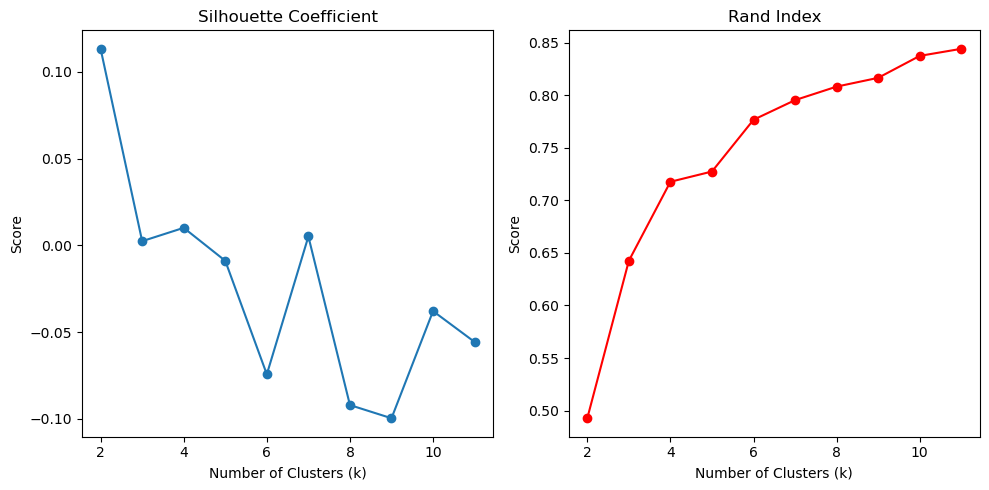

K-means algorithm:
Optimal k for Silhouette Coefficient: 2
Optimal k for Rand Index: 11
NMI for Silhouette Coefficient (k = 2 ): 0.3936222773575649
NMI for Rand Index (k = 11 ): 0.5728103855606871


In [112]:
silhouette_scores = []
rand_index_scores = []


# Iterate over different values of k
for k in k_values:
    # Apply GMM on vowel dataset
    gmm_vowel = GMM(n_components=k)
    gmm_vowel.fit(vowel_features.values)
    gmm_labels_vowel = gmm_vowel.labels

    # Calculate Silhouette Coefficient
    silhouette_score = silhouette_coefficient(vowel_features.values, gmm_labels_vowel)
    silhouette_scores.append(silhouette_score)

    # Calculate Rand Index
    rand_index_score = rand_index(vowel_true_label.values, gmm_labels_vowel)
    rand_index_scores.append(rand_index_score)

# Plot Silhouette Coefficient
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(k_values, silhouette_scores, marker='o')
plt.title('Silhouette Coefficient')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Score')

# Plot Rand Index
plt.subplot(1, 2, 2)
plt.plot(k_values, rand_index_scores, marker='o', color='r')
plt.title('Rand Index')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Score')

plt.tight_layout()
plt.show()

# Find the optimal k for Silhouette Coefficient and Rand Index
optimal_k_silhouette = k_values[np.argmax(silhouette_scores)]
optimal_k_rand_index = k_values[np.argmax(rand_index_scores)]

# Output the selected k values
print("K-means algorithm:")
print("Optimal k for Silhouette Coefficient:", optimal_k_silhouette)
print("Optimal k for Rand Index:", optimal_k_rand_index)

# Calculate and output NMI for the selected k values
# Convert string labels to integers for NMI calculation
vowel_true_label_encoded = label_encoder(vowel_true_label.values)

# Apply K-means with the optimal k values
gmm_optimal_silhouette = GMM(n_components=optimal_k_silhouette)
gmm_optimal_rand_index = GMM(n_components=optimal_k_rand_index)
gmm_optimal_silhouette.fit(vowel_features.values)
gmm_optimal_rand_index.fit(vowel_features.values)

# Get labels
labels_optimal_silhouette = gmm_optimal_silhouette.labels
labels_optimal_rand_index = gmm_optimal_rand_index.labels

# Calculate NMI for the selected k values
nmi_silhouette = NMI(vowel_true_label_encoded, labels_optimal_silhouette)
nmi_rand_index = NMI(vowel_true_label_encoded, labels_optimal_rand_index)

# Output NMI values
print("NMI for Silhouette Coefficient (k =", optimal_k_silhouette, "):", nmi_silhouette)
print("NMI for Rand Index (k =", optimal_k_rand_index, "):", nmi_rand_index)